In [1]:
import os
import re
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import skimage
from skimage.util import invert
import warnings

warnings.filterwarnings("ignore")

In [2]:
def plot_img(img: np.ndarray, size: int = 6) -> None:
    """
    Plot an image.

    Parameters
    ----------
    img : np.ndarray
        Image array.
    figsize : int
        Size of figure. Default 8x8.

    Returns
    -------
    """
    plt.figure(figsize=(size, size))
    skimage.io.imshow(img, cmap="gray")
    plt.show()


def load_and_plot(img_path: str) -> np.ndarray:
    """
    Load the image and plot it. I'm plotting the inverse so that the snake has
    high pixel values and the background has low pixel values.

    Parameters
    ----------
    img_path : str
        Path to image.

    Returns
    -------
    img : np.ndarray
        Inverted image array.
    """
    img = skimage.io.imread(img_path)
    img = invert(img)
    img = make_truly_bw(img)
    plot_img(img)
    return img


def load_img(img_path: str) -> np.ndarray:
    """
    Load the image and plot it. I'm plotting the inverse so that the snake has
    high pixel values and the background has low pixel values.

    Parameters
    ----------
    img_path : str
        Path to image.

    Returns
    -------
    img : np.ndarray
        Inverted image array.
    """
    img = skimage.io.imread(img_path)
    img = invert(img)
    img = make_truly_bw(img)
    return img


def make_truly_bw(img):
    """
    Force all pixels to be black or white.

    Parameters
    ----------
    img : np.ndarray
        Grayscale image array.

    Returns
    -------
    img : np.ndarray
        Image containing only black and white pixel values.
    """
    img = 255 * (img > 100)
    return img


def plot_outline(cropped: np.ndarray, outline: np.ndarray, size: int = 6) -> None:
    """
    Plot an outline of the shape of the snake.

    Parameters
    ----------
    cropped : np.ndarray
        Cropped image of the snake.
    outline : np.ndarray
        A 2D array giving pixel values for an outline.

    Returns
    -------
    None
    """
    plt.figure(figsize=(size, size))
    plt.imshow(cropped, cmap="gray")
    plt.scatter(outline[:, 0], outline[:, 1], s=1, color="red")
    plt.show()

In [3]:
def get_distance_parameter(outline, px_per_cm=8.5):
    """
    Use the outline to construct a distance parameter. tip is 0.

    Parameters
    ----------
    outline : np.ndarray
        Outline shape (front, back, or center) of the snake.
    px_per_cm : float
        Magic number which set the distance scale (in cm) in the image. This
        number comes from knowing a physical distance in the image and seeing
        how many pixels that distance takes up.

    Returns
    ------
    distance : np.ndarray
        This array contains the distance between the outline points (in cm).
    """
    distance = np.cumsum(np.sqrt(np.sum(np.diff(outline, axis=0) ** 2, axis=1)))
    distance = np.insert(distance, 0, 0)
    distance = distance / px_per_cm
    return distance


def get_interp_points(distance, num_points: int = 15):
    """
    Get the points I will do the interpolation on.
    """
    interp_points = np.linspace(distance.min(), distance.max(), num_points)
    return interp_points


def rev_interp_points(distance, num_points: int = 15):
    """
    Get the points I will interpolate on using base as s=0
    """
    interp_points = np.linspace(distance.max(), distance.min(), num_points)
    return interp_points


def get_interpolation(distance: np.ndarray, outline: np.ndarray, num_points: int = 15):
    """Get the interpolation of the line."""
    interpolator = interp1d(
        distance,
        outline,
        bounds_error=False,
        fill_value=0,
        kind="cubic",
        axis=0,
    )
    interp_points = get_interp_points(distance, num_points)
    interpolated_line = interpolator(interp_points)
    return interpolated_line, interpolator


def plot_interpolated_line(
    cropped: np.ndarray,
    outline: np.ndarray,
    interpolated_line: np.ndarray,
    size: int = 8,
):
    """
    Plot the interpolation line over top of the snake image.

    Paramters
    ---------
    cropped : np.ndarray
        Cropped image of the snake.
    outline : np.ndarray
        A 2D array with the outline (front, back, or center) outline of the
        snake. The columns correspond to x and y pixel values.
    interpolated_line : np.ndarray
        A 2D array with the interpolation x and y pixel values for the outline.

    Returns
    -------
    """
    plt.figure(figsize=(size, size))
    plt.imshow(cropped, cmap="gray")
    plt.scatter(outline[:, 0], outline[:, 1], s=5, color="red")
    plt.plot(interpolated_line[:, 0], interpolated_line[:, 1], linewidth=2)
    plt.title("Overlay of interpolated line")
    plt.show()

In [4]:
def check_parameterization(
    interpolated_line: np.ndarray, interpolation_points: np.ndarray
) -> bool:
    """
    Check that the parameterization is "proper."

    A proper parameterization means the derivatives dx/dt and dy/dt exist
    everywhere and are not zero simultaneously.

    Parameters
    ----------
    interpolated_line : np.ndarray
        A 2D array containing the x, y pixel values of the interpolation line.
    interpolation_points : np.ndarray
        Points at which the interpolation took place. These are values of the
        parameter we interpolate from.

    Returns
    -------
    proper : bool
        True if the parameterization is "proper" as described above. False otherwise.
    """
    x = interpolated_line[:, 0]
    y = interpolated_line[:, 1]
    t = interpolation_points
    spacing = np.diff(t)[0]
    dx_dt = np.gradient(x, spacing)
    dy_dt = np.gradient(y, spacing)
    deriv_mag = np.sqrt(dx_dt**2 + dy_dt**2)
    no_nans_x = np.all(~np.isnan(dx_dt))
    no_nans_y = np.all(~np.isnan(dy_dt))
    no_nans = no_nans_x and no_nans_y
    non_zero = np.all(deriv_mag > 0)
    proper = no_nans and non_zero
    return proper


def compute_plot_curvature(
    interpolated_line: np.ndarray,
    interpolation_points: np.ndarray,
    px_per_cm: float = 36.4,
) -> np.ndarray:
    """
    Compute and plot the curvature.

    We compute and plot the curvature of the fit line after some smoothing.

    Parameters
    ----------
    interpolated_line : np.ndarray
        A 2D array containing the x, y pixel values of the interpolation.
    interpolation_points : np.ndarray
        Array containing the points we will do the interpolation at.

    Returns
    -------
    smooth_kappa : np.ndarray
        Array containing the curvature at several points along the snake.
    """
    x = interpolated_line[:, 0] / px_per_cm
    y = interpolated_line[:, 1] / px_per_cm
    t = interpolation_points
    spacing = np.diff(t)[0]
    dx_dt = np.gradient(x, spacing)
    dy_dt = np.gradient(y, spacing)
    d2x_dt = np.gradient(dx_dt, spacing)
    d2y_dt = np.gradient(dy_dt, spacing)
    kappa = np.abs(dx_dt * d2y_dt - d2x_dt * dy_dt) / (
        np.power(dx_dt**2 + dy_dt**2, 3 / 2)
    )
    smooth_interp = interp1d(
        interpolation_points, kappa, kind="cubic", fill_value=0, bounds_error=False
    )

    smooth_points = np.linspace(
        interpolation_points.min(), interpolation_points.max(), 100
    )
    smooth_kappa = smooth_interp(smooth_points)
    plt.plot(interpolation_points, kappa, label="regular")
    plt.plot(smooth_points, smooth_kappa)
    plt.xlabel("Distance along snake (cm)", fontsize=15)
    plt.ylabel(r"Curvature $\kappa$ ($cm^{-1}$)", fontsize=15)
    # plt.legend()
    plt.title("Curvature along the snake.")
    plt.show()
    return smooth_kappa, smooth_points, smooth_interp

In [5]:
def get_height_length_ratio(
    distance_param: np.ndarray, interpolated_line: np.ndarray, px_per_cm: float
):
    head_y = interpolated_line[0, 1]
    base_y = interpolated_line[-1, 1]
    height = np.abs(head_y - base_y) / px_per_cm
    length = distance_param[-1]
    ratio = height / length
    return ratio

In [6]:
def extract_front(cropped: np.ndarray) -> np.ndarray:
    """
    Extract the front of the snake from the image and return the pixel values
    describing the extracted shape.

    Parameters
    ----------
    cropped : np.ndarray
        A cropped image of the snake.

    Returns
    -------
    front : np.ndarray
        A 2D array holding the x,y pixel values of the front of the snake.
    """
    rows = []
    columns = []
    for i in range(cropped.shape[0]):
        if np.any(cropped[i]):
            row_idx = i
            rows.append(row_idx)
            column_idx = np.where(cropped[i])[0][0]
            columns.append(column_idx)
    rows = np.array(rows)
    columns = np.array(columns)
    front = np.array(list(zip(columns, rows)))
    return front


def extract_bottom(cropped: np.ndarray):
    """
    Exctract a line describing the bottom of the snake.

    Extract the back of the snake from the image and return the pixel values
    describing the extracted shape.

    Parameters
    ----------
    cropped : np.ndarray
        A cropped image of the snake.

    Returns
    -------
    back : np.ndarray
        A 2D array holding the x, y pixel values of the back of the snake.
    """
    rows = []
    columns = []
    for i in range(cropped.shape[1]):
        if np.any(cropped[:, i]):
            col_idx = i
            columns.append(col_idx)
            row_idx = np.where(cropped[:, i])[0][-1]
            rows.append(row_idx)
    rows = np.array(rows)
    columns = np.array(columns)
    bottom = np.array(list(zip(columns, rows)))
    return bottom

In [7]:
def leaning_backwards(bottom):
    """
    Tell if the snake is leaning backwards i.e if some part of it's upper
    body is behind the point of departure.
    """
    bot_rows = bottom[:, 1]
    row_diffs = np.diff(bot_rows)
    leaning_back = np.any(row_diffs < -5)
    return leaning_back


def leaning_down(front, bottom):
    """
    Is the snake leaning down according to the front outline.
    """
    leaning_back = leaning_backwards(bottom=bottom)
    tilted_up = tilted_high(front=front)
    if leaning_back or tilted_up:
        down = False
    else:
        top_x = front[0][0]
        bottom_x = front[-1][0]
        x_says_down = top_x > bottom_x
        down = x_says_down
    return down


def tilted_high(front, px_num=350):
    """
    Is the snake reaching up high? Measure the distance between the lowest
    and highest point of the snake and check if it is above a (hand chosen)
    threshold.
    """
    highest_point = front[:, 1].min()
    lowest_point = front[:, 1].max()
    diff = lowest_point - highest_point
    tilted = diff > px_num
    return tilted


def leaning_fill_gap(front, bottom):
    """
    If the snake is bent back with some of it's back hanging
    over the base, don't just use the front as the outline but
    supplement it with some of the bits from the back. Just need
    to take care to not inclcude the high up parts on the back of
    the snake and only include the parts from the base that the
    front does not capture.
    """
    dec_bot = []  # selects the points where i know im on the bottom
    for i in range(bottom.shape[0]):
        diff = bottom[i + 1, 1] - bottom[i, 1]
        if diff < -5:
            dec_bot.append(bottom[i])
            break
        else:
            dec_bot.append(bottom[i])

    # selects the points where we don't have any front coverage
    spec_bot = np.array([tup for tup in dec_bot if tup[0] > front[-10:, 0].max()])
    spec_hybrid = np.vstack((front, spec_bot))
    return spec_hybrid

In [8]:
def hybridize(img: np.ndarray, front: np.ndarray, bottom: np.ndarray) -> np.ndarray:
    """
    Smartly combine the images of the front and the bottom.

    If the snake is leaning down, use the bottom outline. Otherwise
    combine the front and the bottom for a full view.
    """

    front_says_down = leaning_down(front, bottom)
    leaning = leaning_backwards(bottom)
    reaching_high = tilted_high(front)

    # First deal with downward leaning snake
    if front_says_down or not reaching_high:
        # print("bingo")
        hybrid = bottom
        return hybrid
    elif leaning:
        # print("bango")
        try:
            hybrid = leaning_fill_gap(front=front, bottom=bottom)
            return hybrid
        except:
            print("there was a problem with the hybridization")
            hybrid = front
            return hybrid
    else:
        bot_cols = bottom[:, 0]
        extra_cols = list(np.where(bot_cols > np.amax(front[:, 0]))[0])
        extra_bit = bottom[extra_cols]
        hybrid = np.vstack((front, extra_bit))
    return hybrid

## Now i'll test out the algorithms to see if the snake is up or down

First an image i know is leaning down

In [9]:
ims_path = "full_processed/"
f_num = "0041"
img_path = "full_processed/im" + f_num + ".png"  # specify the image we want to use.
down_img = load_img(img_path)

In [10]:
front = extract_front(down_img)
bottom = extract_bottom(down_img)
hybrid = hybridize(down_img, front, bottom)

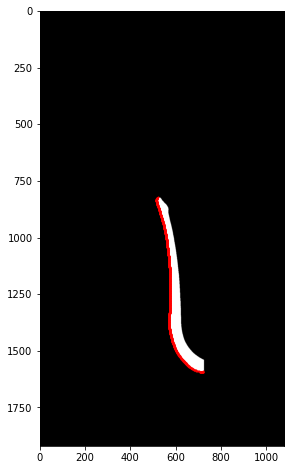

The snake is raising itself high True
The snake is leaning backwards False
The snake is leaning downwards False


In [11]:
plot_outline(down_img, outline=hybrid, size=8)
print(f"The snake is raising itself high {tilted_high(front)}")
print(f"The snake is leaning backwards {leaning_backwards(bottom)}")
print(f"The snake is leaning downwards {leaning_down(front, bottom)}")

In [12]:
files = []
for filename in os.listdir(ims_path):
    if filename.endswith(".png"):
        im_file = os.path.join(ims_path, filename)
        files.append(im_file)


def extract_num_from_npy_string(string):
    numbers = re.findall("[0-9]+", string[-9:])
    numbers = int(numbers[0])
    return numbers


fnames = sorted(files, key=extract_num_from_npy_string)

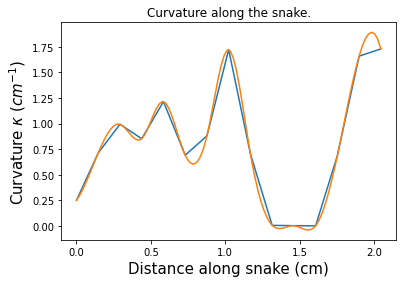

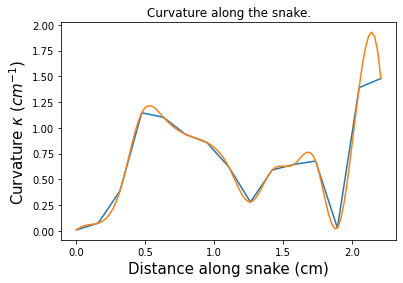

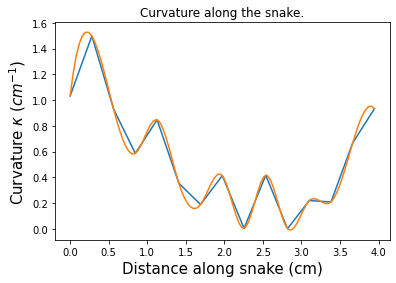

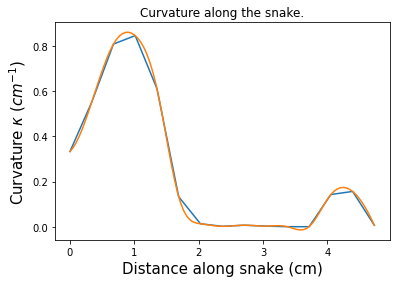

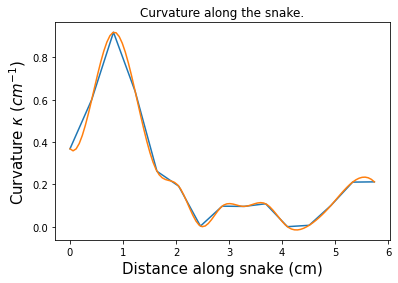

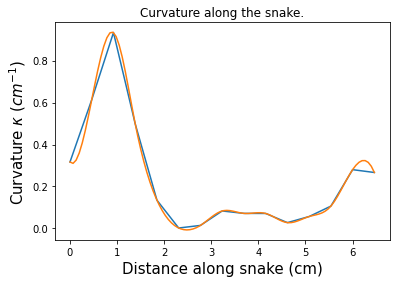

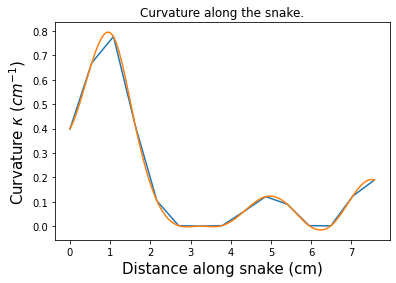

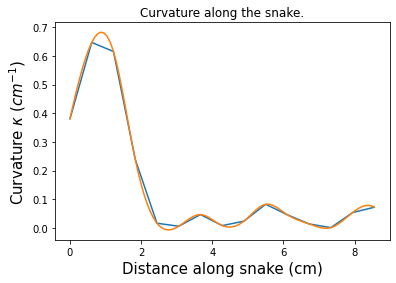

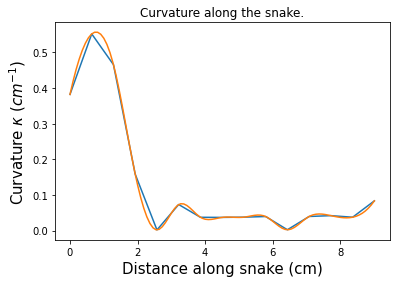

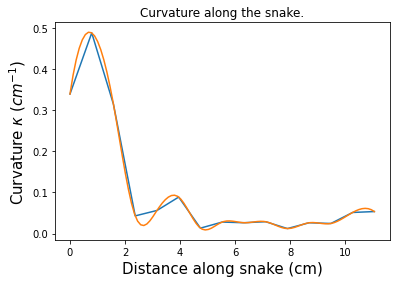

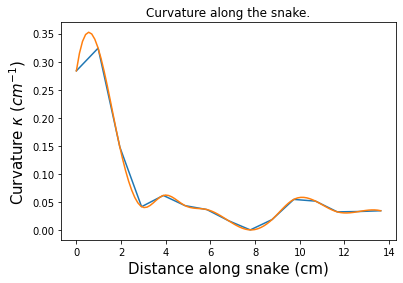

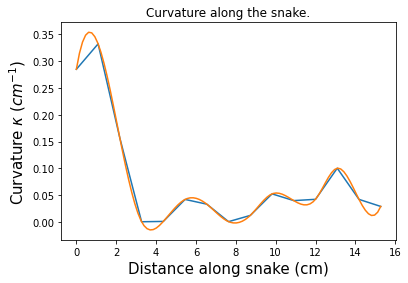

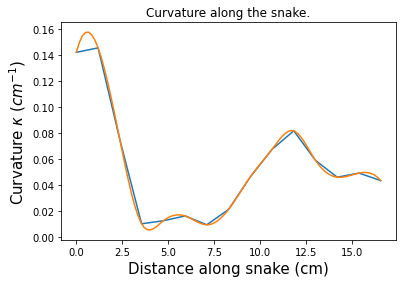

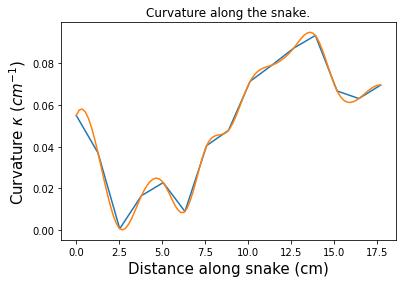

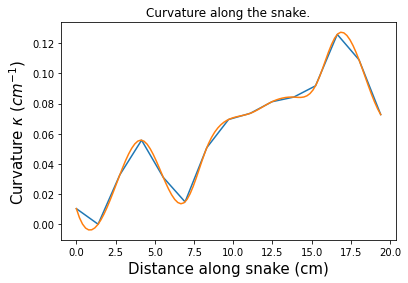

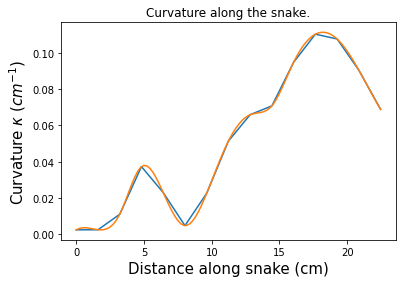

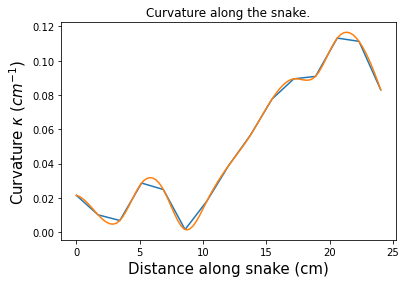

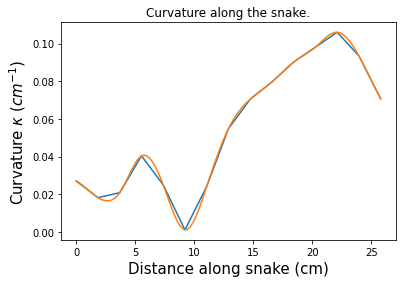

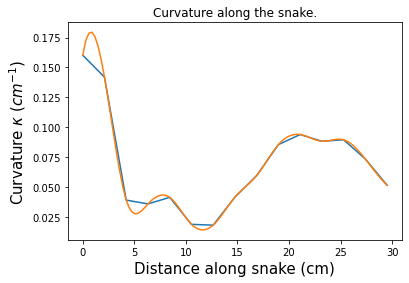

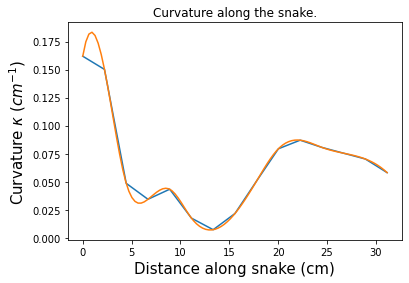

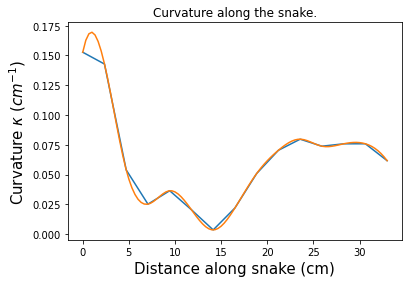

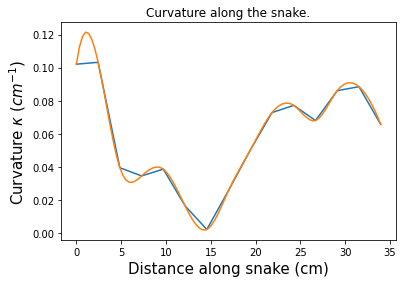

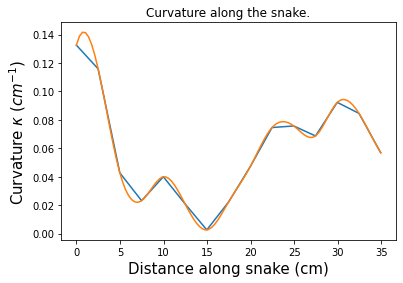

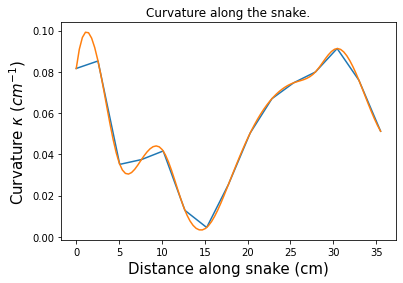

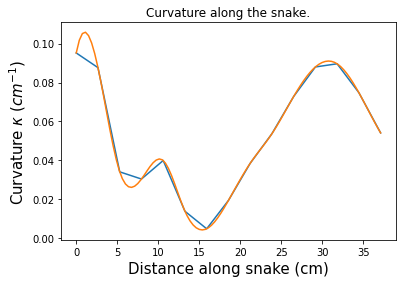

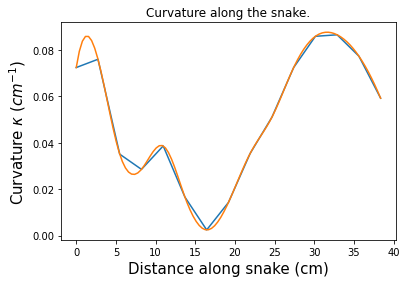

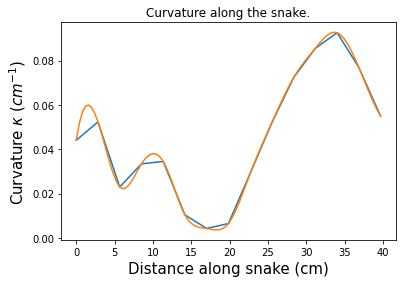

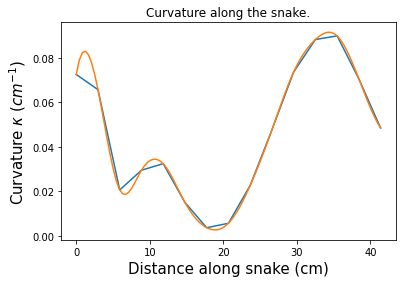

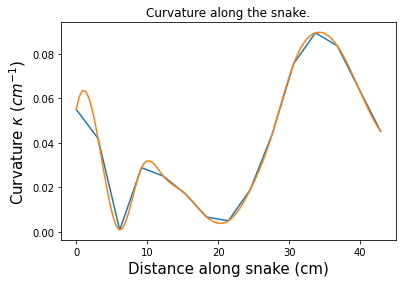

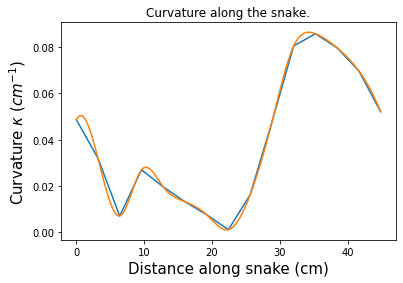

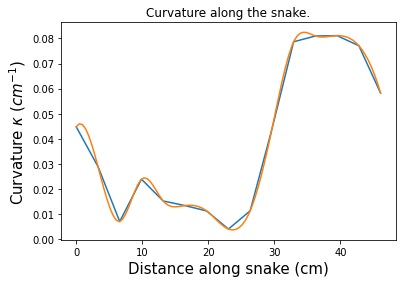

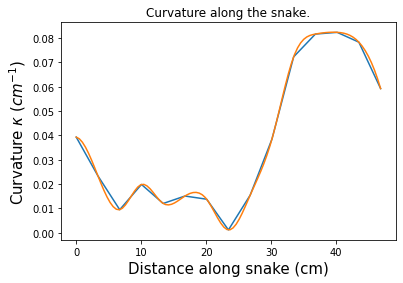

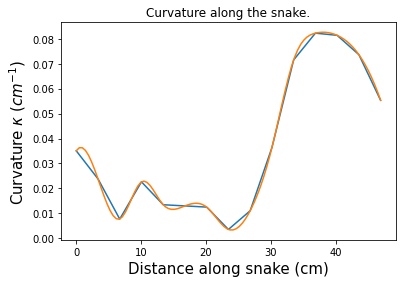

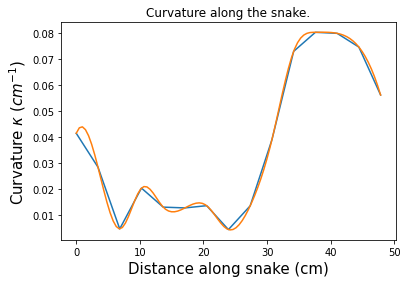

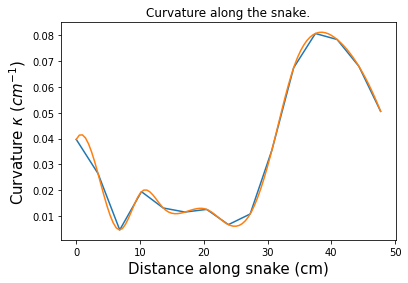

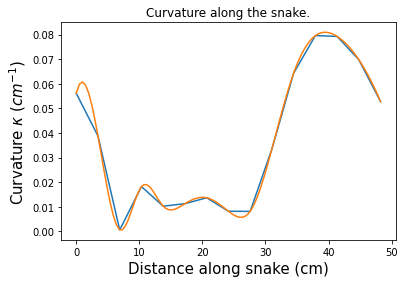

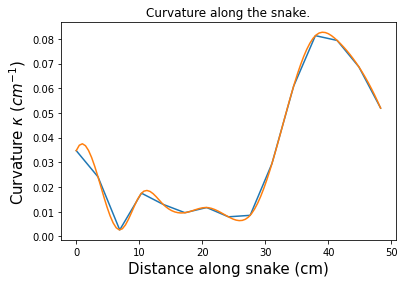

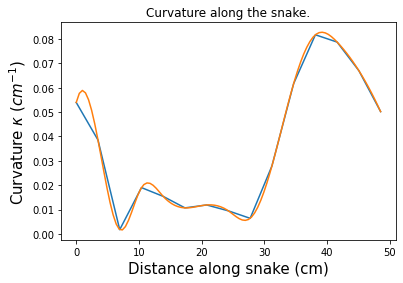

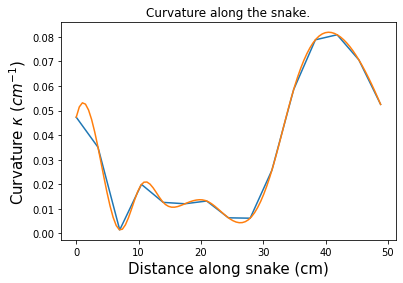

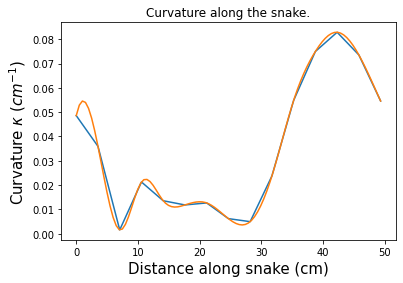

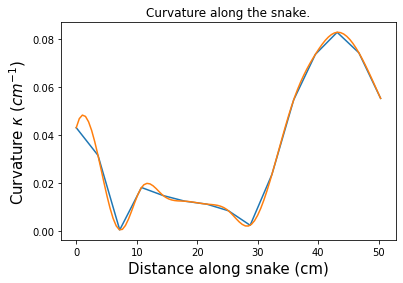

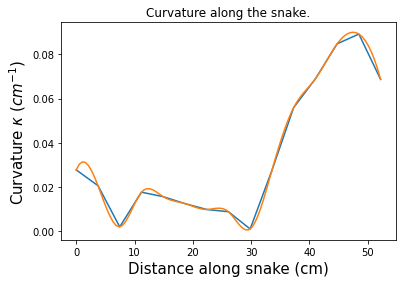

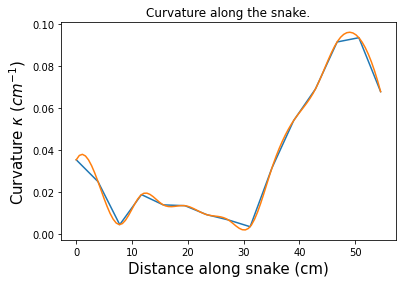

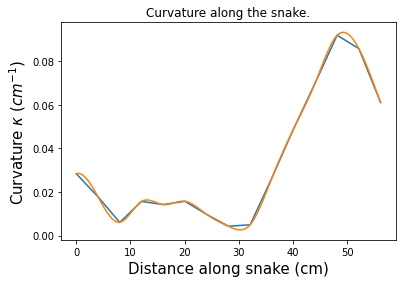

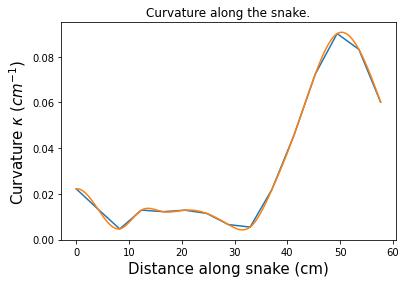

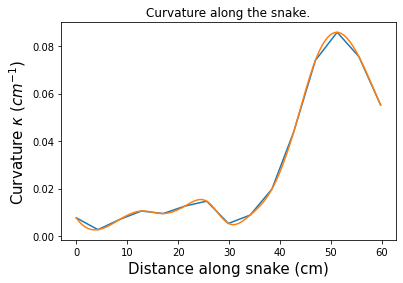

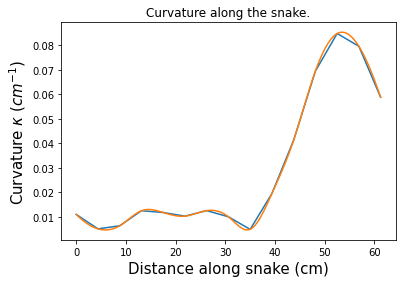

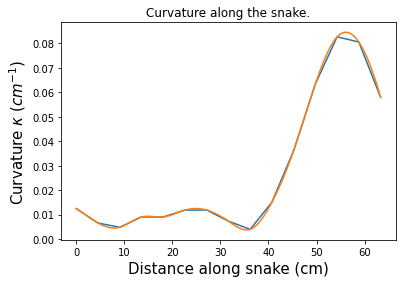

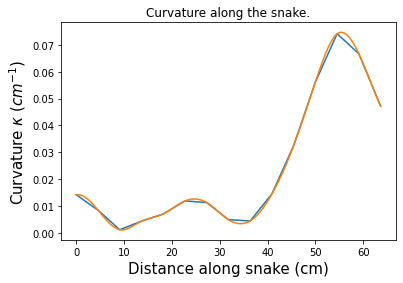

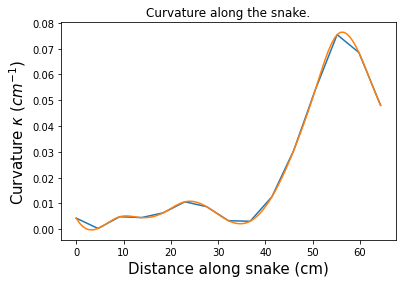

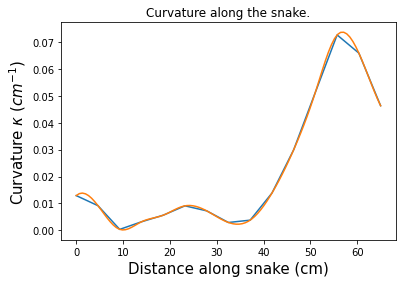

In [13]:
i = 0
for f in fnames:
    os.mkdir(f"test_data/{i}")
    img = load_img(f)
    bottom = extract_bottom(img)
    front = extract_front(img)
    hybrid = hybridize(img, front, bottom)
    distance = get_distance_parameter(outline=hybrid, px_per_cm=17)
    interpolated_line, interpolator = get_interpolation(
        distance[::], hybrid, num_points=15
    )
    interpolation_points = get_interp_points(distance=distance, num_points=15)
    smooth_kappa, smooth_points, smooth_interp = compute_plot_curvature(
        interpolated_line, interpolation_points[::], px_per_cm=17
    )
    with open(f"test_data/{i}/interpolator.pkl", "wb") as f:
        pickle.dump(smooth_interp, f)
    np.savez(
        f"test_data/{i}/arr",
        smooth_points,
    )
    i += 1

### Now that we have an outline of the snake extracted and we have a fit to the outline, we want to extract the curvature profile and plot that. 

We don't have an arc length parametrization because the magnitude of the tangent vector is not one. Instead we have a proper parameterization because the derivatives $\frac{dx}{dt}$ and $\frac{dy}{dt}$ exist everywhere and are not zero simultaneously. To compute curvature we can then use the [following formula](https://en.wikipedia.org/wiki/Curvature)

\begin{equation}
|\kappa| = \frac{|x'y''-x''y'|}{(x'^2+y'^2)^{\frac{3}{2}}}
\end{equation}

In [ ]:
distance = get_distance_parameter(outline=hybrid, px_per_cm=17)
# distance = distance/distance[-1]
# distance = 1 - distance
interpolated_line, interpolator = get_interpolation(distance[::], hybrid, num_points=15)
interpolation_points = get_interp_points(distance=distance, num_points=15)
proper = check_parameterization(
    interpolated_line=interpolated_line, interpolation_points=interpolation_points
)
print(f"The parameterization is proper: {proper}")

In [ ]:
smooth_kappa, smooth_points, smooth_interp = compute_plot_curvature(
    interpolated_line, interpolation_points
)
plot_interpolated_line(
    cropped=down_img, outline=hybrid, interpolated_line=interpolated_line, size=6
)

In [14]:
with open("reaching_num.txt") as f:
    lines = f.readlines()

In [17]:
int(lines[0])

350